In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

In [2]:
test_path = "hdfs://namenode:8020/data/Weather Test Data.csv"
train_path = "hdfs://namenode:8020/data/Weather Training Data.csv"

### Initialize Spark

In [3]:
from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession

In [4]:
sc = SparkContext(master="local[*]")

In [5]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [6]:
spark = SparkSession.builder.appName('australian-weather-prediction-spark').getOrCreate()

### Load Dataset

In [7]:
df_train = spark.read.format("csv").option("header", "true").load(train_path)
df_test = spark.read.format("csv").option("header", "true").load(test_path)

In [8]:
df_train.count()

99516

In [9]:
removed_duplicates = df_train.distinct()

In [10]:
# no duplicates
removed_duplicates.count()

99516

In [11]:
df_train_data = removed_duplicates.drop("row ID")

In [12]:
df_train_data.limit(5).toPandas()

Location MinTemp MaxTemp Rainfall Evaporation Sunshine WindGustDir  \
0   Albury    15.9    26.2     10.2        None     None           N   
1   Albury     4.6    19.9        0        None     None          SW   
2   Albury     7.2    22.9      2.8        None     None         WSW   
3   Albury    17.8    35.5        0        None     None         ENE   
4   Albury    15.9      37        0        None     None         NNW   

  WindGustSpeed WindDir9am WindDir3pm  ... Humidity9am Humidity3pm  \
0            24         NE         NA  ...          82          56   
1            19        SSW          W  ...          82          49   
2            31         SE        WSW  ...          55          32   
3            31        SSE        ESE  ...          52          18   
4            46        ESE         NE  ...          56          23   

  Pressure9am Pressure3pm Cloud9am Cloud3pm Temp9am Temp3pm RainToday  \
0      1010.7      1008.6        7        5    17.6    24.7       Yes   
1      1023.8      1021.1     None     None    10.1    19.5        No   
2      1021.7      1019.7     None     None    13.8    20.8       Yes   
3      1013.2      1009.2     None     None    24.6    34.5        No   
4      1015.2      1010.4     None     None    24.1      35        No   

  RainTomorrow  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 22 columns]

### Data Exploration

In [13]:
df_train_data.toPandas().describe().T

count unique       top   freq
Location       99516     49  Canberra   2393
MinTemp        99073    386        11    649
MaxTemp        99286    500        20    615
Rainfall       98537    601         0  63047
Evaporation    56985    327         4   2296
Sunshine       52199    145         0   1626
WindGustDir    99516     17         W   6843
WindGustSpeed  93036     67        35   6353
WindDir9am     99516     17         N   8052
WindDir3pm     99516     17        SE   7410
WindSpeed9am   98581     43         9   9277
WindSpeed3pm   97681     44        17   8620
Humidity9am    98283    101        99   2362
Humidity3pm    97010    101        52   1931
Pressure9am    89768    536    1016.4    553
Pressure3pm    89780    536    1015.3    549
Cloud9am       61944     10         7  13875
Cloud3pm       59514     10         7  12759
Temp9am        98902    432        17    645
Temp3pm        97612    491      18.5    609
RainToday      99516      3        No  76481
RainTomorrow   99516      2         0  77157

As shown above there are a lot of missing data entries.

In [14]:
from pyspark.sql.functions import col,isnan, when, count

##### List of empty entries for each column

In [15]:
# This shows the list of empty data
df_train_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_train_data.columns]).toPandas().T

0
Location           0
MinTemp          443
MaxTemp          230
Rainfall         979
Evaporation    42531
Sunshine       47317
WindGustDir        0
WindGustSpeed   6480
WindDir9am         0
WindDir3pm         0
WindSpeed9am     935
WindSpeed3pm    1835
Humidity9am     1233
Humidity3pm     2506
Pressure9am     9748
Pressure3pm     9736
Cloud9am       37572
Cloud3pm       40002
Temp9am          614
Temp3pm         1904
RainToday          0
RainTomorrow       0

### Plot Categorical Data

In [16]:
# categorical data plotting
categorical_columns = ["Location", "WindGustDir", "WindDir9am", "WindDir3pm", "RainToday"]

In [17]:
def plot_categorical_data(df, column_name, xlabel, title):
    # data
    data = df.rdd.map(lambda x: x[column_name]).collect()
    counter = Counter(data)
    x, y = counter.keys(), counter.values()
    
    # figure
    plt.figure(figsize=(12, 5))
    plt.bar(x, y, width=0.8, align="center")
    plt.title(title)
    plt.ylabel("Frequency")
    plt.xlabel(xlabel)
    plt.xticks(rotation=90)
    
    # plot text
    for i, (key, value) in enumerate(counter.items()):
        plt.text(i, value, f' {value} ', rotation=90, ha='center', va='top', color="white")
    plt.show()

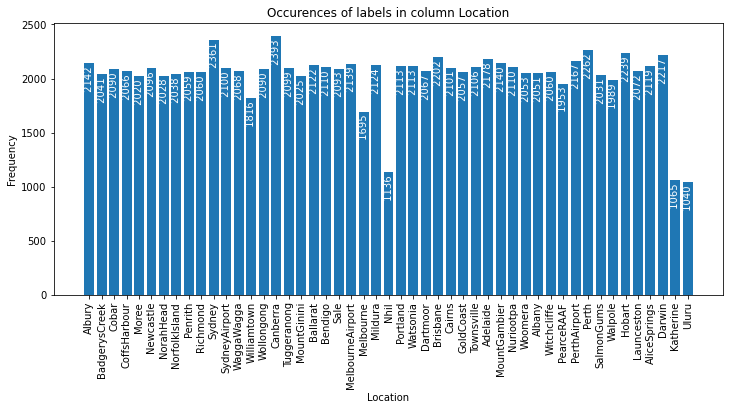

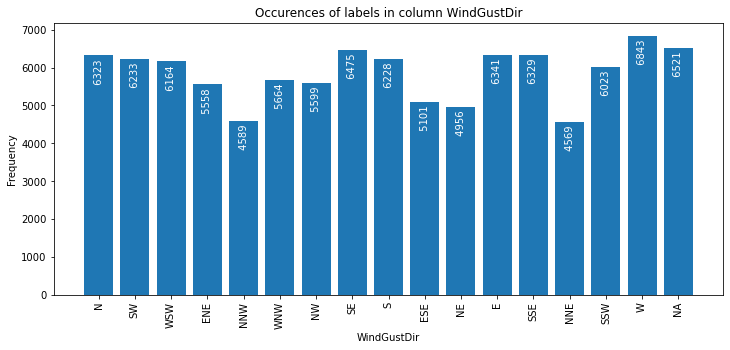

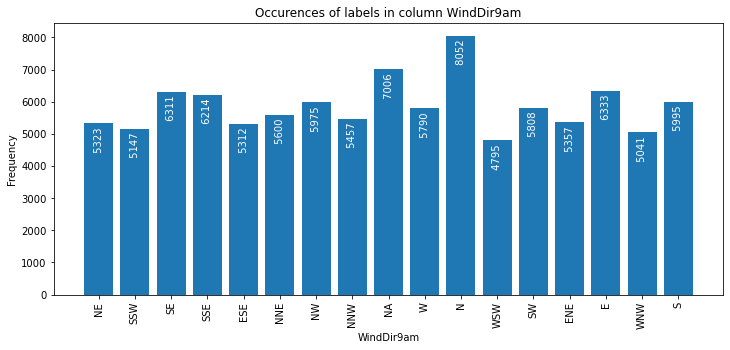

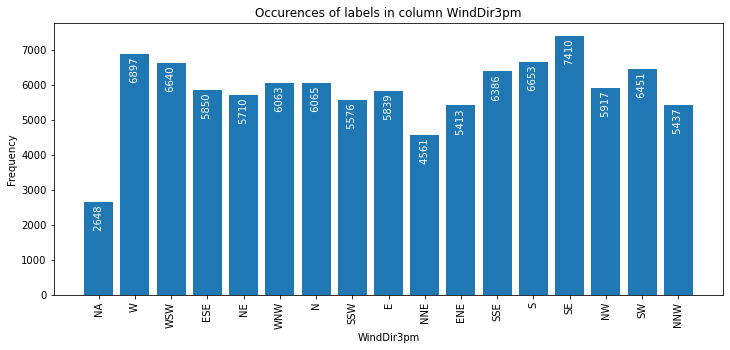

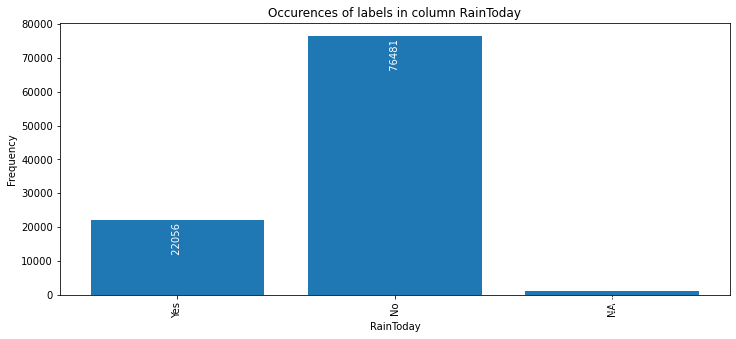

In [18]:
for category in categorical_columns:
    plot_categorical_data(df_train_data, category, category, f"Occurences of labels in column {category}")

## Plot Number Data

In [19]:
int_df = df_train_data.drop(*categorical_columns)
int_df = int_df.drop("RainTomorrow")

In [20]:
int_df.limit(5).toPandas()

MinTemp MaxTemp Rainfall Evaporation Sunshine WindGustSpeed WindSpeed9am  \
0    15.9    26.2     10.2        None     None            24           11   
1     4.6    19.9        0        None     None            19            4   
2     7.2    22.9      2.8        None     None            31            7   
3    17.8    35.5        0        None     None            31            6   
4    15.9      37        0        None     None            46            9   

  WindSpeed3pm Humidity9am Humidity3pm Pressure9am Pressure3pm Cloud9am  \
0            0          82          56      1010.7      1008.6        7   
1           11          82          49      1023.8      1021.1     None   
2           11          55          32      1021.7      1019.7     None   
3           11          52          18      1013.2      1009.2     None   
4           15          56          23      1015.2      1010.4     None   

  Cloud3pm Temp9am Temp3pm  
0        5    17.6    24.7  
1     None    10.1    19.5  
2     None    13.8    20.8  
3     None    24.6    34.5  
4     None    24.1      35

### Distribution

In [21]:
import seaborn as sns
import math

In [22]:
def plot_histogram(df, columns, kind):
    width = math.ceil(len(columns) / 2 )
    fig, axs = plt.subplots(2, width, figsize=(15, 7))
    
    for i, column in enumerate(columns):
        data = df.rdd.map(lambda x: float(x[column]) if (x[column] is not None) else None).collect()
        if kind == "kde":
            sns.kdeplot(data, ax=axs[i % 2, i % width])
        else:
            sns.histplot(data, ax=axs[i % 2, i % width])
        axs[i % 2, i % width].set_title(column)
        
    fig.show()

In [23]:
# kde for float values
kde = ["MinTemp", "MaxTemp", "Rainfall", "Evaporation", "Sunshine", "Pressure9am", "Pressure3pm", "Temp9am", "Temp3pm"]
# histogram for whole numbers
hist = ["WindGustSpeed", "WindSpeed3pm", "Humidity9am", "Humidity3pm", "Cloud9am", "Cloud3pm"]

#### KDE and Histogram

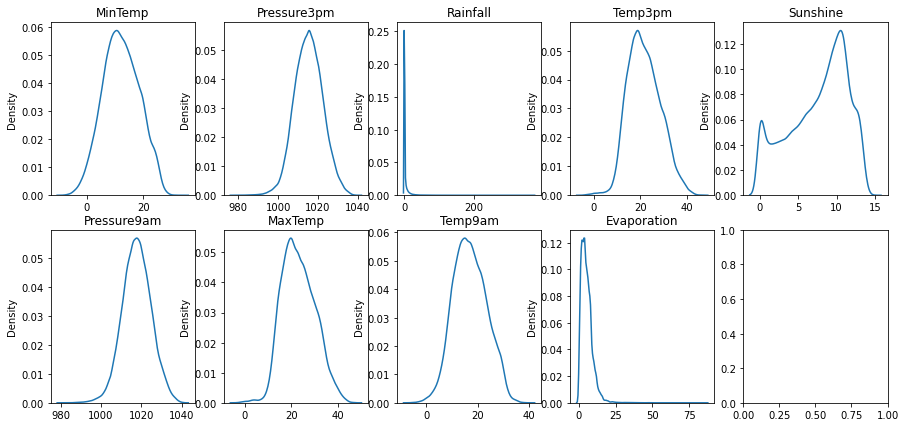

In [24]:
plot_histogram(int_df, kde, "kde")

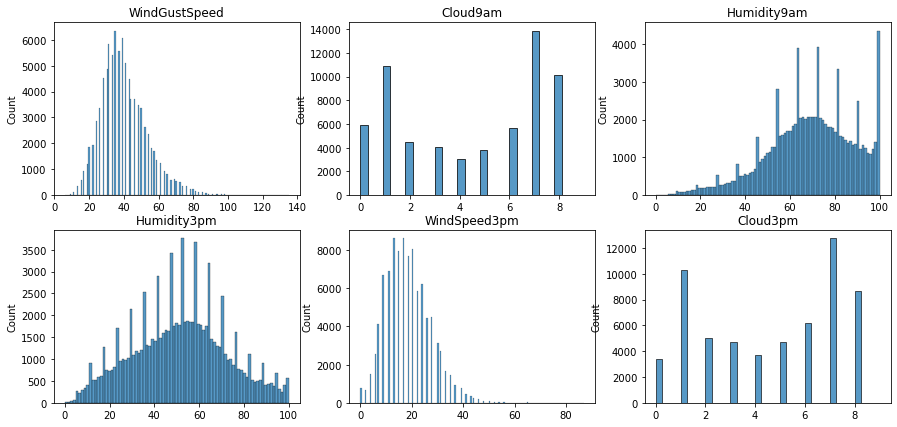

In [25]:
plot_histogram(int_df, hist, "hist")

### Pair Plot

In [26]:
pairplot_df = df_train_data.drop("Location", "WindGustDir", "WindDir9am", "WindDir3pm", "RainToday", "RainTomorrow").toPandas()

In [27]:
df = pairplot_df.astype(float)

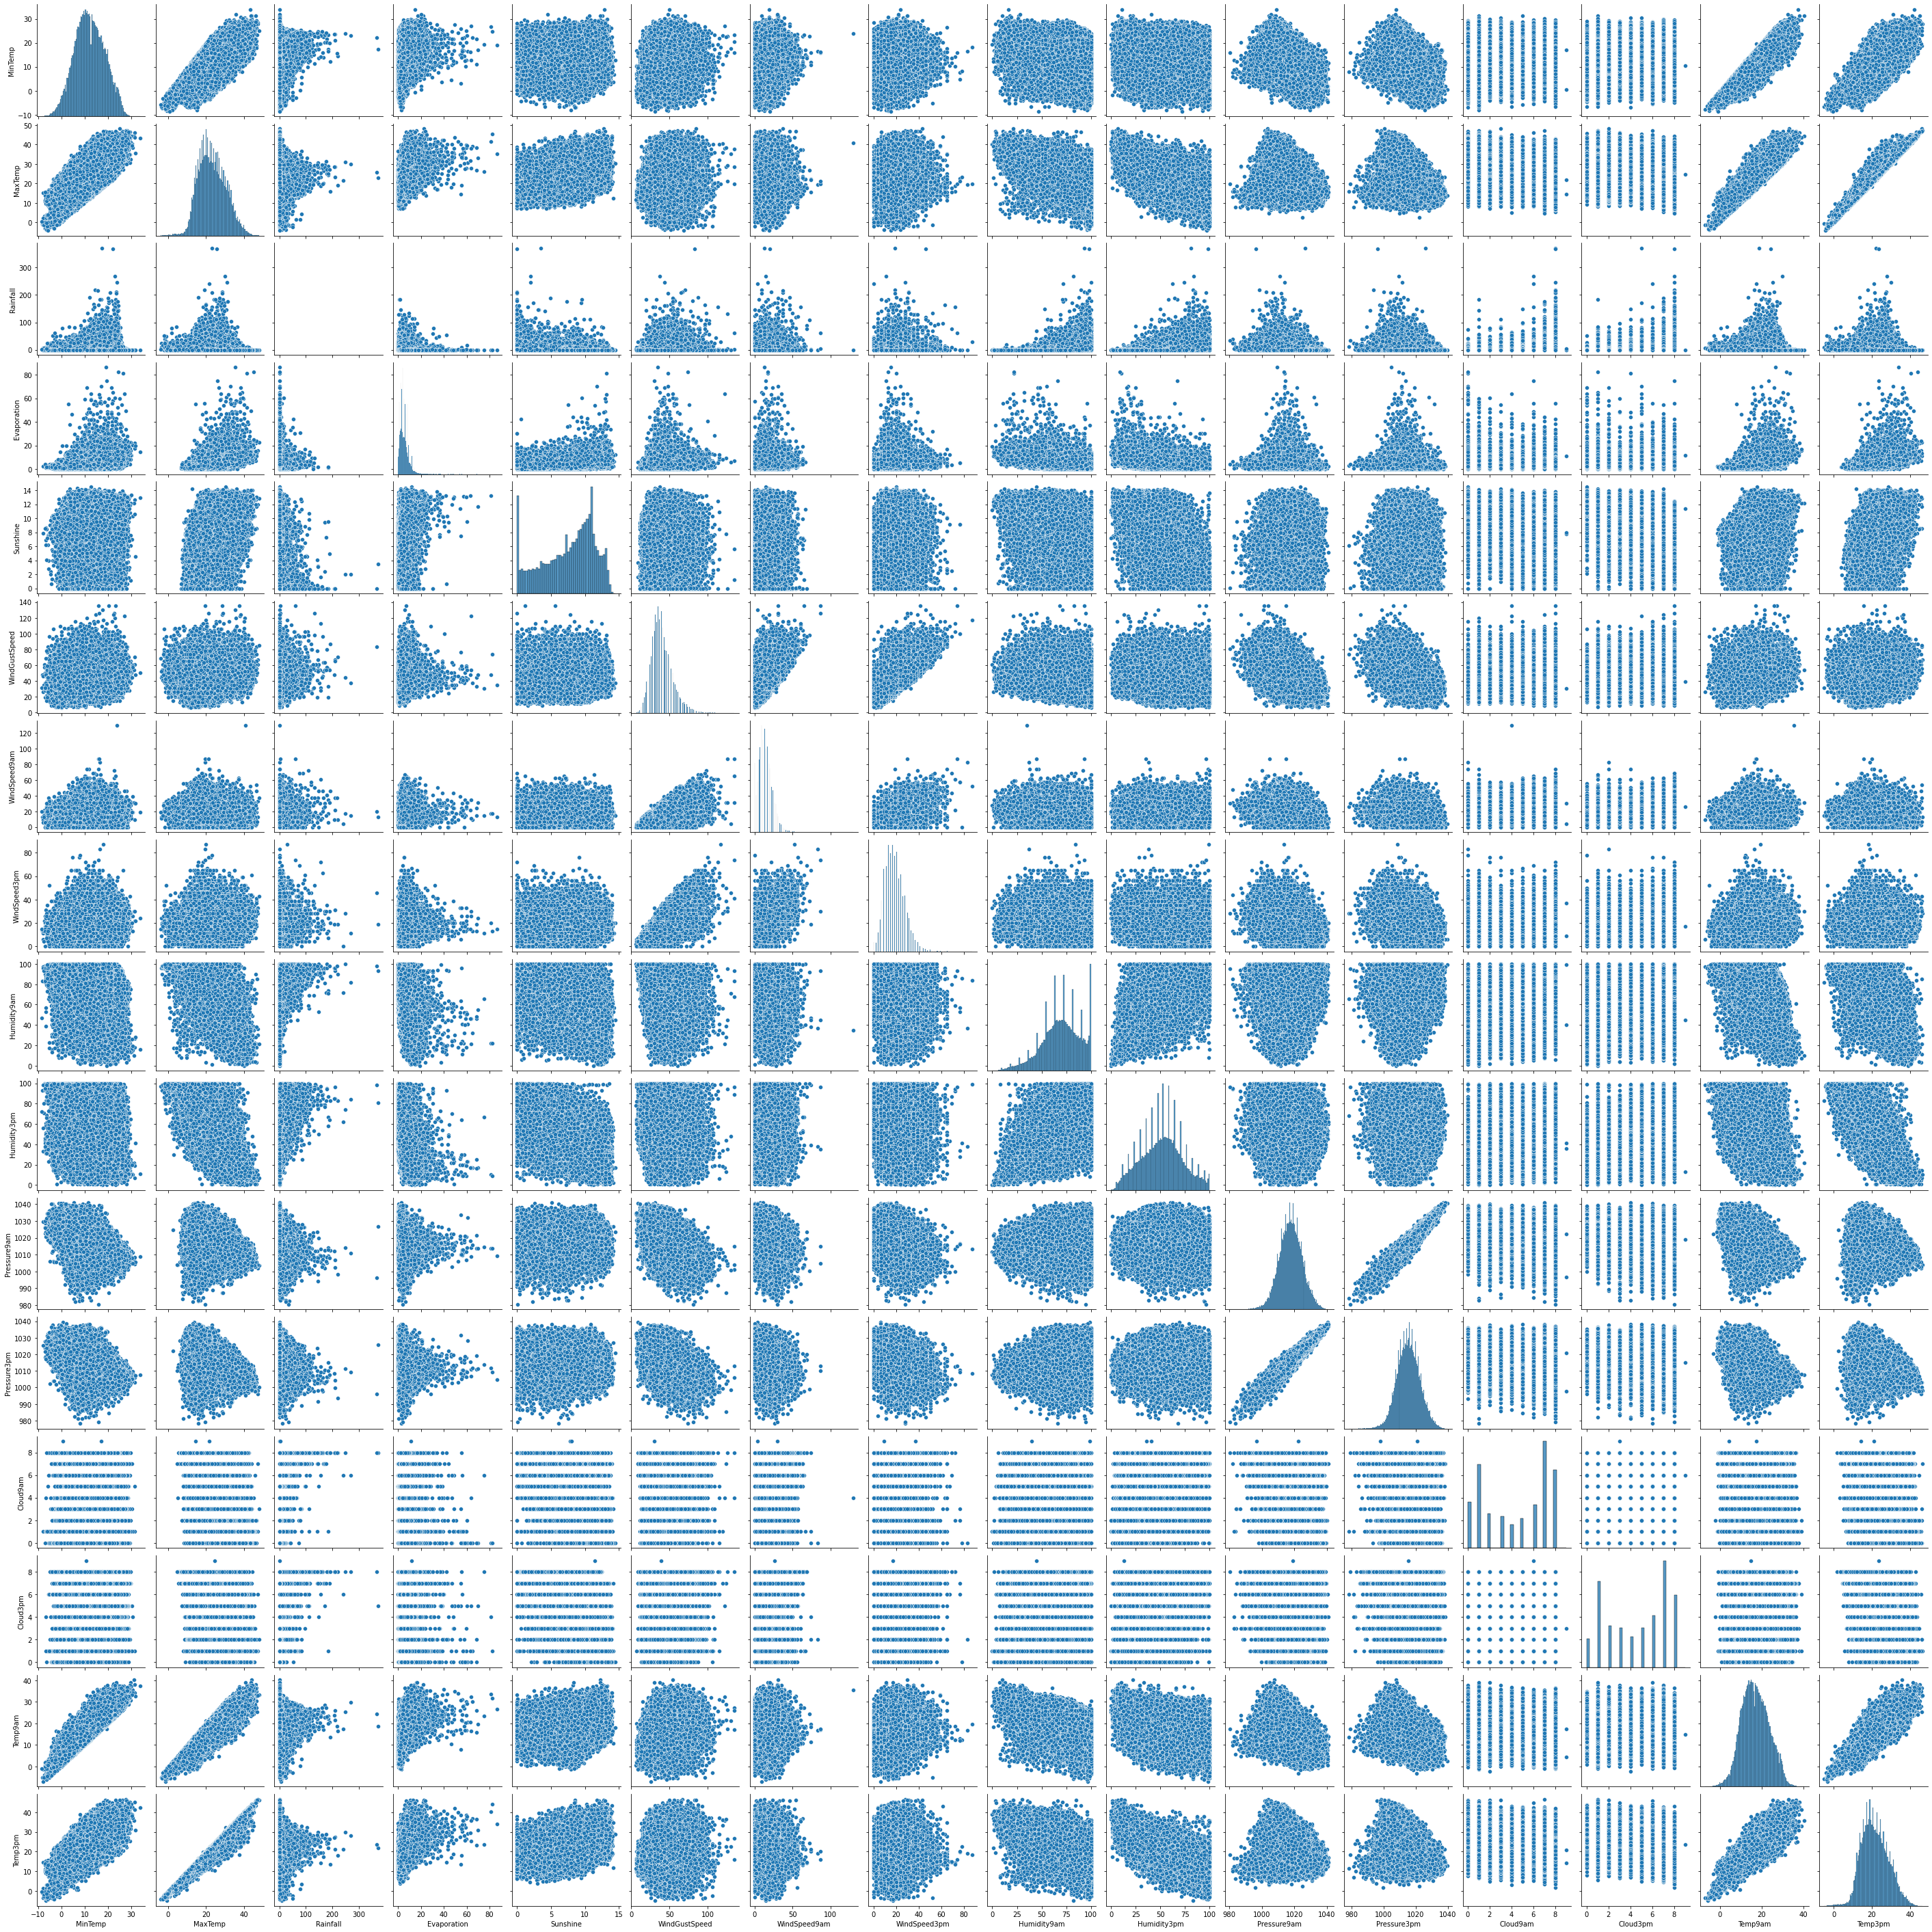

In [28]:
sns.pairplot(df, dropna=True)

<AxesSubplot:>

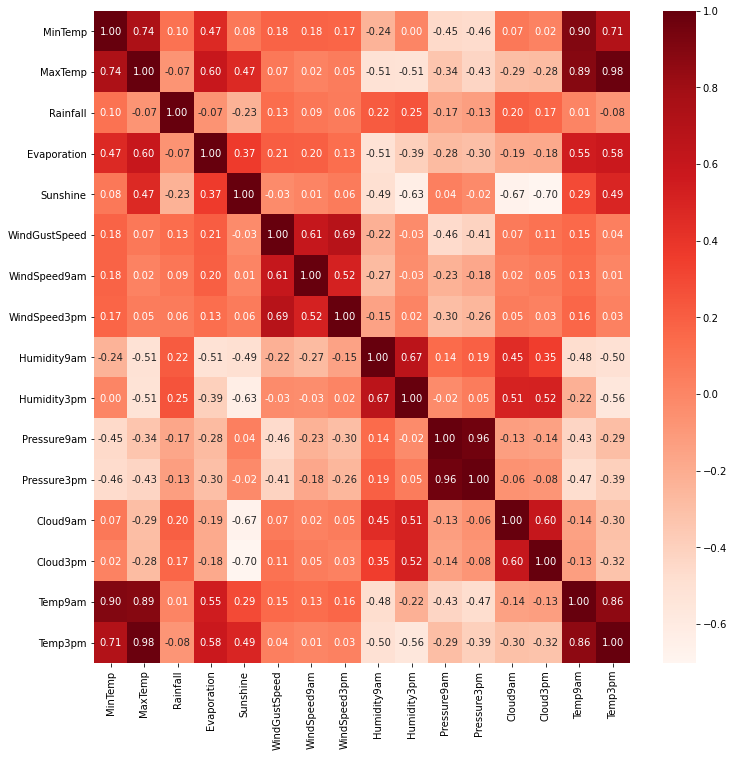

In [29]:
plt.figure(figsize=(12,12))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,fmt='.2f')

## Correlation Analysis

#### Temperature
Temp3pm and MaxTemp has a high correlation with 0.98, which indicates that both features are linearly dependent. Which indicates that, those 1 of the 2 features can be disregarded. Features with high correlation are more linearly dependent and hence have almost the same effect on the dependent variable.

Considering the correlation to be as high as 0.98, we need to drop one of the feature. This is the same case as Temp9am and MinTemp.

Looking into the feature labels, this makes sense as the highest temperature on a day will be usually around mid afternoon and the lowest would be around morning hours.

#### Pressure
Oddly, this trend happends with pressure too, having 9 am and 3 pm to have oddly similar trend. One assumption would be that the feature pressure has no significant change throughout the day.

In [30]:
df_corr_removed = df_train_data.drop("Temp3pm", "Temp9am", "Pressure9am")

In [31]:
df_corr_removed.toPandas()

Location MinTemp MaxTemp Rainfall Evaporation Sunshine WindGustDir  \
0       Albury    15.9    26.2     10.2        None     None           N   
1       Albury     4.6    19.9        0        None     None          SW   
2       Albury     7.2    22.9      2.8        None     None         WSW   
3       Albury    17.8    35.5        0        None     None         ENE   
4       Albury    15.9      37        0        None     None         NNW   
...        ...     ...     ...      ...         ...      ...         ...   
99511    Uluru    22.1    42.7        0        None     None           E   
99512    Uluru     6.5    24.6        0        None     None          SE   
99513    Uluru    13.5    26.4        0        None     None         WSW   
99514    Uluru       8    26.2        0        None     None          NW   
99515    Uluru    24.8    32.6        0        None     None         NNW   

      WindGustSpeed WindDir9am WindDir3pm WindSpeed9am WindSpeed3pm  \
0                24         NE         NA           11            0   
1                19        SSW          W            4           11   
2                31         SE        WSW            7           11   
3                31        SSE        ESE            6           11   
4                46        ESE         NE            9           15   
...             ...        ...        ...          ...          ...   
99511            65          E        ENE           13           31   
99512            31         SE        ESE           19           17   
99513            33          S        WSW            9           15   
99514            28        SSE         NW            6           15   
99515            44        NNE         NW           20           11   

      Humidity9am Humidity3pm Pressure3pm Cloud9am Cloud3pm RainToday  \
0              82          56      1008.6        7        5       Yes   
1              82          49      1021.1     None     None        No   
2              55          32      1019.7     None     None       Yes   
3              52          18      1009.2     None     None        No   
4              56          23      1010.4     None     None        No   
...           ...         ...         ...      ...      ...       ...   
99511          16           9      1011.5     None        3        No   
99512          42          21      1021.2     None     None        No   
99513          34          45      1013.6        8     None        No   
99514          69          35      1014.6        3     None        No   
99515          59          57        1004        4        8        No   

      RainTomorrow  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
99511            0  
99512            0  
99513            1  
99514            0  
99515            1  

[99516 rows x 19 columns]

## Preprocessing

We need to drop entries with too many nulls. Hacing too many nulls will not be helpful for training data as it has low information. 

The threshold will be 4 as it is deemed to be reasonable.

In [32]:
df_corr_removed.limit(5).toPandas()

Location MinTemp MaxTemp Rainfall Evaporation Sunshine WindGustDir  \
0   Albury    15.9    26.2     10.2        None     None           N   
1   Albury     4.6    19.9        0        None     None          SW   
2   Albury     7.2    22.9      2.8        None     None         WSW   
3   Albury    17.8    35.5        0        None     None         ENE   
4   Albury    15.9      37        0        None     None         NNW   

  WindGustSpeed WindDir9am WindDir3pm WindSpeed9am WindSpeed3pm Humidity9am  \
0            24         NE         NA           11            0          82   
1            19        SSW          W            4           11          82   
2            31         SE        WSW            7           11          55   
3            31        SSE        ESE            6           11          52   
4            46        ESE         NE            9           15          56   

  Humidity3pm Pressure3pm Cloud9am Cloud3pm RainToday RainTomorrow  
0          56      1008.6        7        5       Yes            0  
1          49      1021.1     None     None        No            0  
2          32      1019.7     None     None       Yes            0  
3          18      1009.2     None     None        No            0  
4          23      1010.4     None     None        No            0

In [33]:
categorical_columns = ["Location", "WindGustDir", "WindDir9am", "WindDir3pm", "RainToday"]
convert_dict = dict((col, 'float') if col not in categorical_columns else (col, 'string') for col in df_corr_removed.columns)
 
df_train_pd = df_corr_removed.toPandas().astype(convert_dict)

### Drop Nans

In [34]:
df_drop_na = df_train_pd.dropna(how='all', thresh=12)

In [35]:
df_drop_na.head()

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
0   Albury     15.9     26.2      10.2          NaN       NaN           N   
1   Albury      4.6     19.9       0.0          NaN       NaN          SW   
2   Albury      7.2     22.9       2.8          NaN       NaN         WSW   
3   Albury     17.8     35.5       0.0          NaN       NaN         ENE   
4   Albury     15.9     37.0       0.0          NaN       NaN         NNW   

   WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  WindSpeed3pm  \
0           24.0         NE         NA          11.0           0.0   
1           19.0        SSW          W           4.0          11.0   
2           31.0         SE        WSW           7.0          11.0   
3           31.0        SSE        ESE           6.0          11.0   
4           46.0        ESE         NE           9.0          15.0   

   Humidity9am  Humidity3pm  Pressure3pm  Cloud9am  Cloud3pm RainToday  \
0         82.0         56.0       1008.6       7.0       5.0       Yes   
1         82.0         49.0       1021.1       NaN       NaN        No   
2         55.0         32.0       1019.7       NaN       NaN       Yes   
3         52.0         18.0       1009.2       NaN       NaN        No   
4         56.0         23.0       1010.4       NaN       NaN        No   

   RainTomorrow  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0

Since most of the entries have null values at only Evaporation, Sunshine, Cloud9am and Cloud3pm. I will assume that we need at least 12 features present that is not Nan.

In [36]:
df_drop = spark.createDataFrame(df_drop_na)
df_drop.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_drop.columns]).toPandas().T

0
Location           0
MinTemp          186
MaxTemp          133
Rainfall         845
Evaporation    41919
Sunshine       46702
WindGustDir        0
WindGustSpeed   5954
WindDir9am         0
WindDir3pm         0
WindSpeed9am     442
WindSpeed3pm    1362
Humidity9am      921
Humidity3pm     2212
Pressure3pm     9159
Cloud9am       37026
Cloud3pm       39412
RainToday          0
RainTomorrow       0

These features have almost 50% missing values (Nans):
+ Evaporation
+ Sunshine
+ Cloud9am
+ Cloud3pm

Having too much nans is not helpful, so we can remove these columns

In [37]:
df_drop = df_drop.drop("Evaporation", "Sunshine", "Cloud9am", "Cloud3pm")

In [38]:
df_drop.limit(5).toPandas()

Location  MinTemp  MaxTemp  Rainfall WindGustDir  WindGustSpeed WindDir9am  \
0   Albury     15.9     26.2      10.2           N           24.0         NE   
1   Albury      4.6     19.9       0.0          SW           19.0        SSW   
2   Albury      7.2     22.9       2.8         WSW           31.0         SE   
3   Albury     17.8     35.5       0.0         ENE           31.0        SSE   
4   Albury     15.9     37.0       0.0         NNW           46.0        ESE   

  WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
0         NA          11.0           0.0         82.0         56.0   
1          W           4.0          11.0         82.0         49.0   
2        WSW           7.0          11.0         55.0         32.0   
3        ESE           6.0          11.0         52.0         18.0   
4         NE           9.0          15.0         56.0         23.0   

   Pressure3pm RainToday  RainTomorrow  
0       1008.6       Yes           0.0  
1       1021.1        No           0.0  
2       1019.7       Yes           0.0  
3       1009.2        No           0.0  
4       1010.4        No           0.0

### Imputation

In [39]:
df_drop.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_drop.columns]).toPandas().T

0
Location          0
MinTemp         186
MaxTemp         133
Rainfall        845
WindGustDir       0
WindGustSpeed  5954
WindDir9am        0
WindDir3pm        0
WindSpeed9am    442
WindSpeed3pm   1362
Humidity9am     921
Humidity3pm    2212
Pressure3pm    9159
RainToday         0
RainTomorrow      0

In [40]:
# zero imputation
from pyspark.ml.feature import Imputer

In [41]:
categorical_columns = ["Location", "WindGustDir", "WindDir9am", "WindDir3pm", "RainToday", "RainTomorrow"]
impute_column = [columns for columns in df_drop.columns if columns not in categorical_columns]

In [42]:
imputer = Imputer(inputCols=impute_column, outputCols=[f"{a}_imputed" for a in impute_column]).setStrategy("mean")
imputed_df = imputer.fit(df_drop).transform(df_drop).drop(*impute_column)

In [43]:
for c in imputed_df.columns:
    if c not in categorical_columns:
        imputed_df = imputed_df.withColumnRenamed(c, c.replace("_imputed", ""))

In [44]:
imputed_df.limit(5).toPandas()

Location WindGustDir WindDir9am WindDir3pm RainToday  RainTomorrow  MinTemp  \
0   Albury           N         NE         NA       Yes           0.0     15.9   
1   Albury          SW        SSW          W        No           0.0      4.6   
2   Albury         WSW         SE        WSW       Yes           0.0      7.2   
3   Albury         ENE        SSE        ESE        No           0.0     17.8   
4   Albury         NNW        ESE         NE        No           0.0     15.9   

   MaxTemp  WindSpeed3pm  WindSpeed9am  Rainfall  WindGustSpeed  Humidity3pm  \
0     26.2           0.0          11.0      10.2           24.0         56.0   
1     19.9          11.0           4.0       0.0           19.0         49.0   
2     22.9          11.0           7.0       2.8           31.0         32.0   
3     35.5          11.0           6.0       0.0           31.0         18.0   
4     37.0          15.0           9.0       0.0           46.0         23.0   

   Humidity9am  Pressure3pm  
0         82.0       1008.6  
1         82.0       1021.1  
2         55.0       1019.7  
3         52.0       1009.2  
4         56.0       1010.4

### Convert categorical data

In [45]:
# One hot encoding
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [46]:
def convert_to_one_hot(column, df):
    indexer = StringIndexer(inputCol=column, outputCol=f"{column}_numeric").fit(df)
    index = indexer.transform(df)
    index = index.drop(column)
    encoder = OneHotEncoder(inputCol=f'{column}_numeric', outputCol=f'{column}_vector').fit(index)
    index = encoder.transform(index)
    index = index.drop(f'{column}_numeric')
    return index, indexer, encoder

### One hot encoding

In [47]:
encoders = dict()

In [48]:
categorical_columns = ["Location", "WindGustDir", "WindDir9am", "WindDir3pm", "RainToday"]

In [49]:
encoded_df = imputed_df

In [50]:
for columns in categorical_columns:
    encoded_df, indexer, encoder = convert_to_one_hot(columns, encoded_df)
    encoders[columns] = {"encoder": encoder, "indexer": indexer}
    encoded_df = encoded_df.withColumnRenamed(f"{columns}_vector", columns)

In [51]:
encoded_df.limit(5).toPandas()

RainTomorrow  MinTemp  MaxTemp  WindSpeed3pm  WindSpeed9am  Rainfall  \
0           0.0     15.9     26.2           0.0          11.0      10.2   
1           0.0      4.6     19.9          11.0           4.0       0.0   
2           0.0      7.2     22.9          11.0           7.0       2.8   
3           0.0     17.8     35.5          11.0           6.0       0.0   
4           0.0     15.9     37.0          15.0           9.0       0.0   

   WindGustSpeed  Humidity3pm  Humidity9am  Pressure3pm  \
0           24.0         56.0         82.0       1008.6   
1           19.0         49.0         82.0       1021.1   
2           31.0         32.0         55.0       1019.7   
3           31.0         18.0         52.0       1009.2   
4           46.0         23.0         56.0       1010.4   

                                            Location  \
0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
1  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
2  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
3  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
4  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   

                                         WindGustDir  \
0  (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...   
1  (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
2  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...   
3  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                          WindDir9am  \
0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...   
4  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                          WindDir3pm   RainToday  
0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  (0.0, 1.0)  
1  (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  (1.0, 0.0)  
2  (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  (0.0, 1.0)  
3  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  (1.0, 0.0)  
4  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  (1.0, 0.0)

### Feature Scaling

In [52]:
categorical_columns = ["Location", "WindGustDir", "WindDir9am", "WindDir3pm", "RainToday", "RainTomorrow"]

In [53]:
from pyspark.ml.feature import StandardScaler
def scale_data(data, column):
    scaler = StandardScaler(inputCol=column, outputCol=f"{column}_scaled", withStd=True, withMean=True)
    scalerModel = scaler.fit(data)
    scaled_df = scalerModel.transform(data)
    scaled_df = scaled_df.drop(f'{column}')
    return scaled_df, scalerModel

In [54]:
non_categorical_columns = [columns for columns in encoded_df.columns if columns not in categorical_columns]

In [55]:
scaled_df = encoded_df

In [56]:
from pyspark.ml.feature import VectorAssembler
non_category_assembler = VectorAssembler(inputCols=non_categorical_columns, outputCol="non_category_features")
scaled_df = non_category_assembler.transform(scaled_df)
scaled_df, scaler = scale_data(scaled_df, "non_category_features")
scaled_df = scaled_df.drop(*non_categorical_columns)

In [57]:
scaled_df.show()

+------------+---------------+---------------+---------------+---------------+-------------+----------------------------+
|RainTomorrow|       Location|    WindGustDir|     WindDir9am|     WindDir3pm|    RainToday|non_category_features_scaled|
+------------+---------------+---------------+---------------+---------------+-------------+----------------------------+
|         0.0| (48,[8],[1.0])| (16,[4],[1.0])|(16,[13],[1.0])|     (16,[],[])|(2,[1],[1.0])|        [0.58220613982464...|
|         0.0| (48,[8],[1.0])| (16,[5],[1.0])|(16,[14],[1.0])| (16,[1],[1.0])|(2,[0],[1.0])|        [-1.1883905332693...|
|         0.0| (48,[8],[1.0])| (16,[7],[1.0])| (16,[3],[1.0])| (16,[3],[1.0])|(2,[1],[1.0])|        [-0.7809966084866...|
|         0.0| (48,[8],[1.0])|(16,[12],[1.0])| (16,[4],[1.0])| (16,[9],[1.0])|(2,[0],[1.0])|        [0.87991708485814...|
|         0.0| (48,[8],[1.0])|(16,[15],[1.0])|(16,[12],[1.0])|(16,[11],[1.0])|(2,[0],[1.0])|        [0.58220613982464...|
|         1.0| (48,[8],[

### Compile features into one column

In [58]:
removed_label = scaled_df.columns
removed_label.remove("RainTomorrow")

In [59]:
removed_label

['Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'non_category_features_scaled']

In [60]:
assembler = VectorAssembler(inputCols=removed_label, outputCol="features")

In [61]:
scaled_df.show()

+------------+---------------+---------------+---------------+---------------+-------------+----------------------------+
|RainTomorrow|       Location|    WindGustDir|     WindDir9am|     WindDir3pm|    RainToday|non_category_features_scaled|
+------------+---------------+---------------+---------------+---------------+-------------+----------------------------+
|         0.0| (48,[8],[1.0])| (16,[4],[1.0])|(16,[13],[1.0])|     (16,[],[])|(2,[1],[1.0])|        [0.58220613982464...|
|         0.0| (48,[8],[1.0])| (16,[5],[1.0])|(16,[14],[1.0])| (16,[1],[1.0])|(2,[0],[1.0])|        [-1.1883905332693...|
|         0.0| (48,[8],[1.0])| (16,[7],[1.0])| (16,[3],[1.0])| (16,[3],[1.0])|(2,[1],[1.0])|        [-0.7809966084866...|
|         0.0| (48,[8],[1.0])|(16,[12],[1.0])| (16,[4],[1.0])| (16,[9],[1.0])|(2,[0],[1.0])|        [0.87991708485814...|
|         0.0| (48,[8],[1.0])|(16,[15],[1.0])|(16,[12],[1.0])|(16,[11],[1.0])|(2,[0],[1.0])|        [0.58220613982464...|
|         1.0| (48,[8],[

In [62]:
categorical_columns = ["Location", "WindGustDir", "WindDir9am", "WindDir3pm", "RainToday", "non_category_features_scaled"]
df = assembler.transform(scaled_df).drop(*categorical_columns)

In [63]:
df = df.drop("non_category_features")

In [64]:
df

DataFrame[RainTomorrow: double, features: vector]

# Model Training

In [65]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [66]:
(trainingData, validationData) = df.randomSplit([0.8, 0.2])

In [67]:
eval_accuracy = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
eval_precision = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="precisionByLabel")
eval_recall = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="recallByLabel")
eval_f1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1")

In [82]:
def evaluate(predictions):
    accuracy = eval_accuracy.evaluate(predictions)
    prec = eval_precision.evaluate(predictions)
    f1 = eval_f1.evaluate(predictions)
    recall = eval_recall.evaluate(predictions)
    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": prec,
        "recall": recall
    }

In [134]:
import seaborn as sns
def plot_confusion_matrix(predictions, title):
    x_axis_labels = ['No Rain Tomorrow', 'Rain Tomorrow']
    y_axis_labels = ['Rain Tomorrow', 'No Rain Tomorrow']
    result = sc.parallelize(predictions.rdd.map(lambda row: (row.prediction, row.indexedLabel)).collect())
    metric = MulticlassMetrics(result)
    cf_matrix = metric.confusionMatrix().toArray()
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues', xticklabels=x_axis_labels, yticklabels=y_axis_labels).set(title=title)

### Random Forest

In [84]:
from pyspark.ml.classification import RandomForestClassifier

In [85]:
labelIndexer = StringIndexer(inputCol="RainTomorrow", outputCol="indexedLabel").fit(df)
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features", numTrees=10)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

In [86]:
pipeline = Pipeline(stages=[labelIndexer, rf, labelConverter])
# Train model.  This also runs the indexers.
rf_model = pipeline.fit(trainingData)

In [87]:
rf_predictions = rf_model.transform(validationData)

In [88]:
rf_evaluation = evaluate(rf_predictions)

In [89]:
rf_evaluation

{'accuracy': 0.8232600271752806,
 'f1': 0.7902281188991225,
 'precision': 0.8262374333901006,
 'recall': 0.9773214633829359}

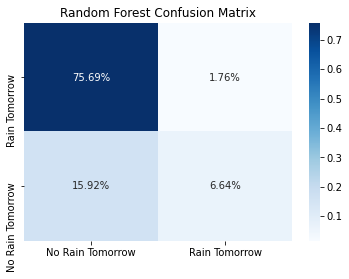

In [135]:
plot_confusion_matrix(rf_predictions, "Random Forest Confusion Matrix")

### Gradient Boosted

In [91]:
from pyspark.ml.classification import GBTClassifier

In [92]:
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=20)

In [93]:
gbt_pipeline = Pipeline(stages=[labelIndexer, gbt])
gbt_model = pipeline.fit(trainingData)
gbt_predictions = gbt_model.transform(validationData)

In [94]:
gbt_evaluation = evaluate(gbt_predictions)

In [95]:
gbt_evaluation

{'accuracy': 0.8232600271752806,
 'f1': 0.7902281188991225,
 'precision': 0.8262374333901006,
 'recall': 0.9773214633829359}

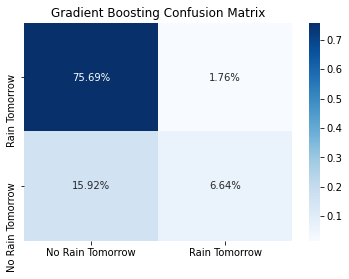

In [136]:
plot_confusion_matrix(gbt_predictions, "Gradient Boosting Confusion Matrix")

### Clustering

In [97]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import DoubleType

In [98]:
kmeans = KMeans().setK(2).setSeed(1)
kmeans_model = kmeans.fit(trainingData.drop("RainTomorrow"))

In [99]:
kmeans_predictions = kmeans_model.transform(validationData)

In [100]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features')
silhouette = evaluator.evaluate(kmeans_predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.2359453796050207


In [101]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(trainingData.drop("RainTomorrow"))
pca_transformed = pca_model.transform(validationData)

In [102]:
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

In [103]:
cluster_assignment = np.array(kmeans_predictions.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

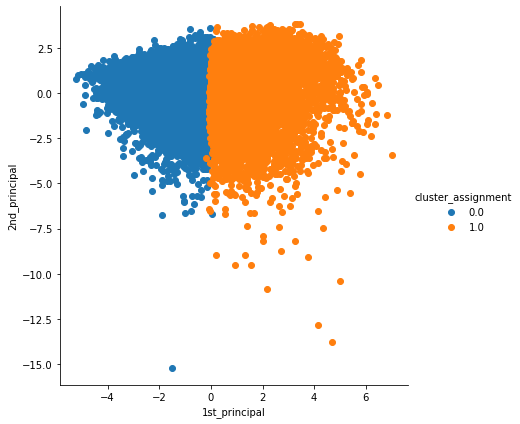

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca, cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df, hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()

### Random Forest Regressor

In [105]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [106]:
rf_r = RandomForestRegressor(featuresCol="indexedFeatures")

In [107]:
rfr_model = pipeline.fit(trainingData)
rfr_predictions = rfr_model.transform(validationData)

In [108]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(rfr_predictions)

In [109]:
rfr_evaluation = evaluate(rfr_predictions)

## Model Result

#### Drop unwanted columns

In [110]:
df_test_features = df_test.drop("row ID", "Evaporation", "Sunshine", "Cloud9am", "Cloud3pm", "Temp3pm", "Temp9am", "Pressure9am")

#### Convert to float

In [111]:
categorical_columns = ["Location", "WindGustDir", "WindDir9am", "WindDir3pm", "RainToday"]
convert_dict = dict((col, 'float') if col not in categorical_columns else (col, 'string') for col in df_test_features.columns)
df_test_pd = df_test_features.toPandas().astype(convert_dict)

In [112]:
df_test_features = spark.createDataFrame(df_test_pd)

#### Impute

In [113]:
categorical_columns = ["Location", "WindGustDir", "WindDir9am", "WindDir3pm", "RainToday", "RainTomorrow"]
impute_column = [columns for columns in df_test_features.columns if columns not in categorical_columns]
imputedtest_df = imputer.fit(df_test_features).transform(df_test_features).drop(*impute_column)

In [114]:
for c in imputedtest_df.columns:
    if c not in categorical_columns:
        imputedtest_df = imputedtest_df.withColumnRenamed(c, c.replace("_imputed", ""))

#### One hot

In [115]:
categorical_columns = ["Location", "WindGustDir", "WindDir9am", "WindDir3pm", "RainToday"]

In [116]:
df_test_features = imputedtest_df

In [117]:
for column in categorical_columns:
    encoder, indexer = encoders[column]["encoder"], encoders[column]["indexer"]
    df_test_features = indexer.transform(df_test_features)
    df_test_features = df_test_features.drop(column)
    df_test_features = encoder.transform(df_test_features)
    df_test_features = df_test_features.drop(f'{column}_numeric')
    df_test_features = df_test_features.withColumnRenamed(f"{column}_vector", column)

In [118]:
df_test_features = non_category_assembler.transform(df_test_features)
df_test_features = scaler.transform(df_test_features)
df_test_features = df_test_features.drop(*non_categorical_columns)

In [119]:
df_test_features

DataFrame[Location: vector, WindGustDir: vector, WindDir9am: vector, WindDir3pm: vector, RainToday: vector, non_category_features: vector, non_category_features_scaled: vector]

In [120]:
categorical_columns = ["Location", "WindGustDir", "WindDir9am", "WindDir3pm", "RainToday", "non_category_features_scaled"]
df_test_features = assembler.transform(df_test_features).drop(*categorical_columns)
df_test_features = df_test_features.drop("non_category_features")

In [121]:
df_test_features

DataFrame[features: vector]

In [189]:
def plot_test(data, xlabel, title):
    counter = Counter(data)
    x, y = counter.keys(), counter.values()
    
    # figure
    plt.figure(figsize=(12, 5))
    plt.bar(x, y, width=0.8, align="center")
    plt.title(title)
    plt.ylabel("Frequency")
    plt.xlabel(xlabel)
    plt.xticks(rotation=90)
    
    # plot text
    for i, (key, value) in enumerate(counter.items()):
        plt.text(i, value, f' {value} ', rotation=90, ha='center', va='top', color="white")
    plt.show()

### Random Forest

In [202]:
rf_test_predictions = rf_model.transform(df_test_features)

In [203]:
data = rf_test_predictions.select("prediction").rdd.map(lambda r: str(int(r.prediction))).collect()

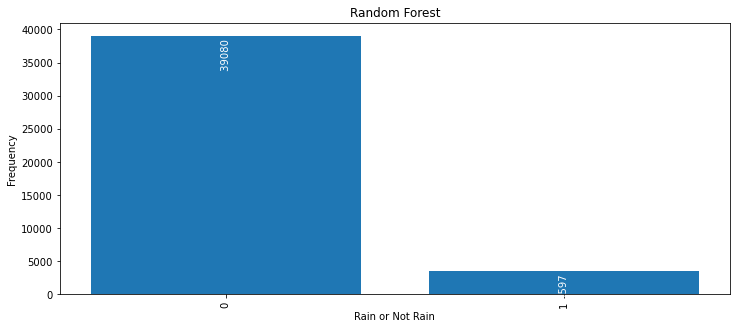

In [204]:
plot_test(data, "Rain or Not Rain", "Random Forest")

### Gradient Boosting

In [205]:
gbt_test_predictions = gbt_model.transform(df_test_features)

In [206]:
data = gbt_test_predictions.select("prediction").rdd.map(lambda r: str(int(r.prediction))).collect()

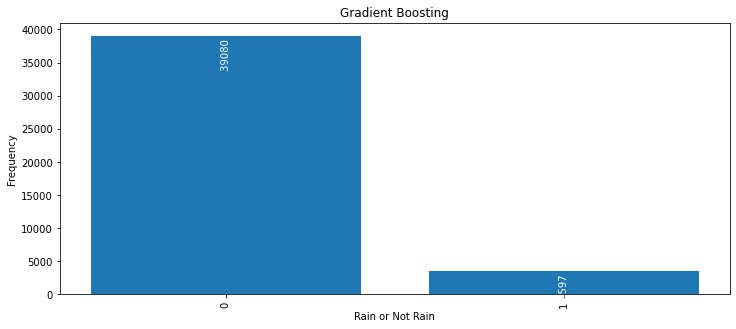

In [207]:
plot_test(data, "Rain or Not Rain", "Gradient Boosting")

### Kmeans

In [208]:
kmeans_test_predictions = kmeans_model.transform(df_test_features)

In [209]:
data = kmeans_test_predictions.select("prediction").rdd.map(lambda r: str(int(r.prediction))).collect()

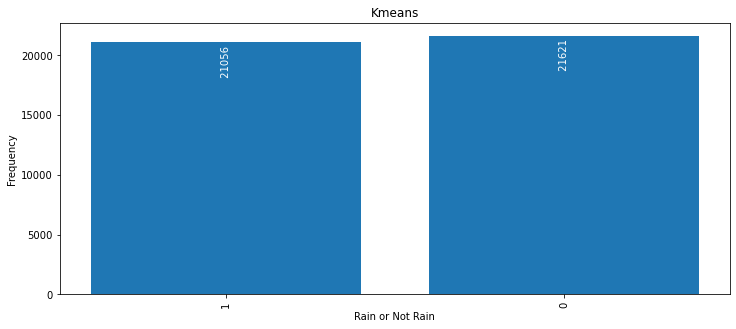

In [210]:
plot_test(data, "Rain or Not Rain", "Kmeans")

In [211]:
rfr_test_predictions = rfr_model.transform(df_test_features)

In [212]:
data = rfr_test_predictions.select("prediction").rdd.map(lambda r: str(int(r.prediction))).collect()

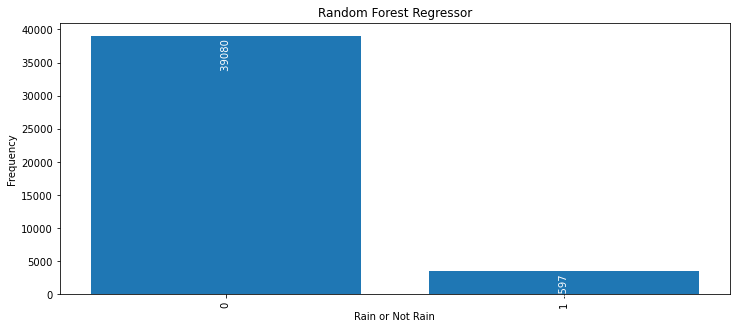

In [213]:
plot_test(data, "Rain or Not Rain", "Random Forest Regressor")